In [29]:
import os
import sys

#!{sys.executable} -m pip install python-csv
# !{sys.executable} -m pip install pandas > >(grep -v 'Requirement already satisfied' 1>&2)
#!{sys.executable} -m pip install python-csv
# !{sys.executable} -m pip install rstr > >(grep -v 'Requirement already satisfied' 1>&2)

sys.path.insert(1, 'lib')

from lib.simulator.template_reader import TemplateReader
from lib.display import Display

reader = TemplateReader(os.getcwd(), 'rki')
df = reader.get_program().drop(columns=['English', 'Info (English)'])

Display.header('RKI survey template', 'h1')
print(f'Number of questions: {df.shape[0]}')
Display.frame(df)

Number of questions: 23


,Questionnaire Name,Order,Question Name,Required,Condition,German,Info (German),Answer Type,Answers,Range
0,S1,1,Sex,True,NaN,Welches Geschlecht wurde bei Ihrer Geburt in Ihre Geburtsurkunde eingetragen?,NaN,Single select,gender_at_birth,NaN
1,S1,2,Sex_A,True,NaN,Da sich nicht alle Menschen ihrem eingetragenen Geschlecht zugehörig fühlen: Welchem Geschlecht fühlen Sie sich zugehörig?,NaN,Single select,gender_identified,NaN
2,S1,3,Gebm_Gebj,True,NaN,"Wann sind Sie geboren?\nBitte geben Sie den Monat und das Jahr an, in dem Sie geboren wurden.",NaN,Month,NaN,NaN
3,S1,4,HS1,True,NaN,Wie ist Ihr Gesundheitszustand im Allgemeinen? \nEr ist...,NaN,Single select,rating_sclae_without_excellent,NaN
4,S1,5,CD1A,True,NaN,Es geht nun um dauerhafte Krankheiten und chronische Gesundheitsprobleme. Bitte berücksichtigen Sie dabei keine vorübergehenden gesundheitlichen Probleme.\n\nHatten Sie in den letzten 12 Monaten eine der folgenden Krankheiten oder Beschwerden?\n\nArthrose. Nicht gemeint ist Arthritis bzw. Gelenksentzündung.,NaN,Single select,yes_no,NaN
5,S1,6,CD1B,True,NaN,"Allergien wie Heuschnupfen, allergische Reaktionen der Augen oder der Haut, Lebensmittelallergien oder andere Allergien. \nNicht gemeint ist allergisches Asthma",NaN,Single select,yes_no,NaN
6,S1,7,CD1C,True,NaN,"Asthma, einschließlich allergisches Asthma",NaN,Single select,yes_no,NaN
7,S1,8,CD1D,True,NaN,"Bluthochdruck bzw. Hypertonie, behandelt oder unbehandelt",NaN,Single select,yes_no,NaN
8,S1,9,CD1E,True,NaN,Erhöhte Blutfette oder erhöhte Cholesterinwerte,NaN,Single select,yes_no,NaN
9,S1,10,CD1F,True,NaN,"Zuckerkrankheit/Diabetes, kein Schwangerschaftsdiabetes",NaN,Single select,yes_no,NaN


In [30]:
from lib.simulator.survey_generator import SurveyGenerator, EnroledUser
import pandas as pd

generator = SurveyGenerator(reader)
    
columns = 'ALP_ID', 'EXTERNAL_ID', 'STATUS', 'START_DATE', 'END_DATE'
users_df = pd.DataFrame(columns=columns)
    
users_count = 100
user_suspended = 10

for i in range(100):
    enrolled = (i >= 10)
    user = EnroledUser(enrolled)
    users_df = users_df.append(user.to_json(), ignore_index=True)
    generator.add_survey(user.id, user.enroled_on, False)

Display.header('Save ALP tables to CSV', 'h1')

Display.header('Participants dataframe', 'h2')
print(f'Number of participants: {users_df.shape[0]}')
df = users_df[users_df['STATUS'] == 'enrolled']
Display.frame(df, 3)

Display.header('Responses dataframe', 'h2')
responses_df = generator.get_all()
print(f'Number of responses: {responses_df.shape[0]}')
Display.frame(responses_df, 3)

Number of participants: 100


,ALP_ID,EXTERNAL_ID,STATUS,START_DATE,END_DATE
10,239f90b8-a1a6-7dba-663f-ebd4bb64231f,anonymous,enrolled,2021-04-29,NaT
11,49d8c4d1-ebc8-13e1-3968-38a44f447b75,anonymous,enrolled,2021-09-02,NaT
12,9a35cc8c-71a1-72e8-7882-2db87c4b2f9d,anonymous,enrolled,2021-02-09,NaT


Number of responses: 2022


,ALP_ID,VERSION,QUESTIONNAIRE,STATUS,AUTHORED,LINK_ID,VALUE,VALUECODING_CODE,LANGUAGE,TEXT,INTERACTION_ID
0,e35e6a9f-1cef-c0e1-6d78-8a953335354f,1.0.0,S1,completed,2022-03-06,Sex,NaN,female,de,Welches Geschlecht wurde bei Ihrer Geburt in Ihre Geburtsurkunde eingetragen?,1
1,e35e6a9f-1cef-c0e1-6d78-8a953335354f,1.0.0,S1,completed,2022-03-06,Sex_A,NaN,female,de,Da sich nicht alle Menschen ihrem eingetragenen Geschlecht zugehörig fühlen: Welchem Geschlecht fühlen Sie sich zugehörig?,1
2,e35e6a9f-1cef-c0e1-6d78-8a953335354f,1.0.0,S1,completed,2022-03-06,Gebm_Gebj,1937-05,NaN,de,"Wann sind Sie geboren?\nBitte geben Sie den Monat und das Jahr an, in dem Sie geboren wurden.",1


In [31]:
from lib.disk import Disk
from enum import Enum
class Folders(Enum):
    RKI_SAVE = 1
    
disk = Disk(Folders.RKI_SAVE.name)
disk.save_participants(users_df)
disk.save_responses(responses_df)

In [32]:
from mock_db import Database

db = Database(Folders.RKI_SAVE) 
Display.header('Read ALP tables from CSV', 'h1')

Display.header('Participants table', 'h2')
original_participants_df = db.get_participants()
print('Number of users:', original_participants_df.shape[0])
Display.frame(original_participants_df, 5)

Display.header('Responses table', 'h2')
responses_df = db.get_responses().drop(columns=['INTERACTION_ID'])
print('Number of responses:', responses_df.shape[0])
Display.frame(responses_df, 5)

Number of users: 100


,ALP_ID,EXTERNAL_ID,STATUS,START_DATE,END_DATE
0,e35e6a9f-1cef-c0e1-6d78-8a953335354f,anonymous,suspended,2022-03-06,2022-03-30
1,2b82a3f2-71d3-2724-50cf-19d42c1522a6,anonymous,suspended,2021-08-27,2022-03-30
2,be42bf5b-f095-667a-c08c-3fb4b9e5c69a,anonymous,suspended,2022-02-28,2022-03-30
3,8c30c539-a773-3fad-8e27-453a7874ca03,anonymous,suspended,2021-09-14,2022-03-30
4,19b8c37c-45b3-21e9-0910-92ade27f8442,anonymous,suspended,2021-04-17,2022-03-30


Number of responses: 2022


,ALP_ID,VERSION,QUESTIONNAIRE,STATUS,AUTHORED,LINK_ID,VALUE,VALUECODING_CODE,LANGUAGE,TEXT
0,e35e6a9f-1cef-c0e1-6d78-8a953335354f,1.0.0,S1,completed,2022-03-06,Sex,NaN,female,de,Welches Geschlecht wurde bei Ihrer Geburt in Ihre Geburtsurkunde eingetragen?
1,e35e6a9f-1cef-c0e1-6d78-8a953335354f,1.0.0,S1,completed,2022-03-06,Sex_A,NaN,female,de,Da sich nicht alle Menschen ihrem eingetragenen Geschlecht zugehörig fühlen: Welchem Geschlecht fühlen Sie sich zugehörig?
2,e35e6a9f-1cef-c0e1-6d78-8a953335354f,1.0.0,S1,completed,2022-03-06,Gebm_Gebj,1937-05,NaN,de,"Wann sind Sie geboren? Bitte geben Sie den Monat und das Jahr an, in dem Sie geboren wurden."
3,e35e6a9f-1cef-c0e1-6d78-8a953335354f,1.0.0,S1,completed,2022-03-06,HS1,NaN,bad,de,Wie ist Ihr Gesundheitszustand im Allgemeinen? Er ist...
4,e35e6a9f-1cef-c0e1-6d78-8a953335354f,1.0.0,S1,completed,2022-03-06,CD1A,NaN,no,de,Es geht nun um dauerhafte Krankheiten und chronische Gesundheitsprobleme. Bitte berücksichtigen Sie dabei keine vorübergehenden gesundheitlichen Probleme. Hatten Sie in den letzten 12 Monaten eine der folgenden Krankheiten oder Beschwerden? Arthrose. Nicht gemeint ist Arthritis bzw. Gelenksentzündung.


In [33]:
from lib.participant_builder import ParticipantsBuilder
from lib.studies.rki_panel_study import RkiPanelStudy
ParticipantsBuilder

from datetime import datetime 
from math import floor

def get_age_group(date_birth):
    if pd.isnull(date_birth): return 'None' 
    age = (datetime.now() - date_birth).days / 365
    dec_year = 10 * floor(age/10)
    return f'{dec_year:03}-{10+dec_year:03}'

df = ParticipantsBuilder(PanelStudy(), original_participants_df, responses_df) \
    .add_choice('S1','Sex', 'Gender') \
    .add_answer('S1','Gebm_Gebj', 'Birth') \
    .add_choice('S1','CD1A', 'Arthrose') \
    .add_choice('S1','CD1B', 'Allergien') \
    .add_choice('S1','CD1C', 'Asthma') \
    .add_choice('S1','CD1D', 'Bluthochdruck') \
    .add_choice('S1','CD1E', 'Cholesterin') \
    .add_choice('S1','CD1F', 'Diabetes') \
    .add_choice('S1','CD1G', 'Rückenleiden') \
    .add_choice('S1','CD1H', 'Depression') \
    .add_answer('S1','BM1', 'Height') \
    .add_answer('S1','BM2', 'Weight') \
    .add_choice('S1','SK1A', 'Smoking') \
    .add_choice('S1','KAspodauz2B', 'Sport') \
    .add_choice('S1','HSA1Aa1', 'Education') \
    .add_choice('S1','ERWTOa', 'Employment') \
    .get()

df["Birth"] = pd.to_datetime(df["Birth"], format='%Y-%m', errors='coerce')  
df['AgeGroup'] = df.apply(lambda row : get_age_group(row['Birth']), axis = 1)

demo_df = df

Display.header('Demographics', 'h1')
Display.header('Dataframe', 'h2')
demo_df.head()

,ALP_ID,EXTERNAL_ID,STATUS,START_DATE,END_DATE,ENROLED_ON,Gender,Birth,Arthrose,Allergien,...,Diabetes,Rückenleiden,Depression,Height,Weight,Smoking,Sport,Education,Employment,AgeGroup
0,e35e6a9f-1cef-c0e1-6d78-8a953335354f,anonymous,suspended,2022-03-06,2022-03-30,2022-03-06,female,1937-05-01,no,yes,...,yes,no,yes,204,124,not_smoking,between_4h_5h,abitur,geringfügig_erwerbstätig,080-090
1,2b82a3f2-71d3-2724-50cf-19d42c1522a6,anonymous,suspended,2021-08-27,2022-03-30,2021-08-27,female,1976-10-01,no,yes,...,no,no,no,137,168,sometimes,less_than_1h,no_abschluss,ruhestand,040-050
2,be42bf5b-f095-667a-c08c-3fb4b9e5c69a,anonymous,suspended,2022-02-28,2022-03-30,2022-02-28,female,2001-09-01,yes,no,...,yes,yes,yes,159,172,not_anymore,between_2h_3h,abschluss_7y,kurzarbeit,020-030
3,8c30c539-a773-3fad-8e27-453a7874ca03,anonymous,suspended,2021-09-14,2022-03-30,2021-09-14,female,1994-02-01,no,no,...,no,yes,yes,149,150,sometimes,less_than_1h,realschule,arbeitslos,020-030
4,19b8c37c-45b3-21e9-0910-92ade27f8442,anonymous,suspended,2021-04-17,2022-03-30,2021-04-17,female,1986-08-01,no,no,...,yes,yes,yes,169,130,daily,between_6h_7h,no_abschluss,unemployed_other_reason,030-040


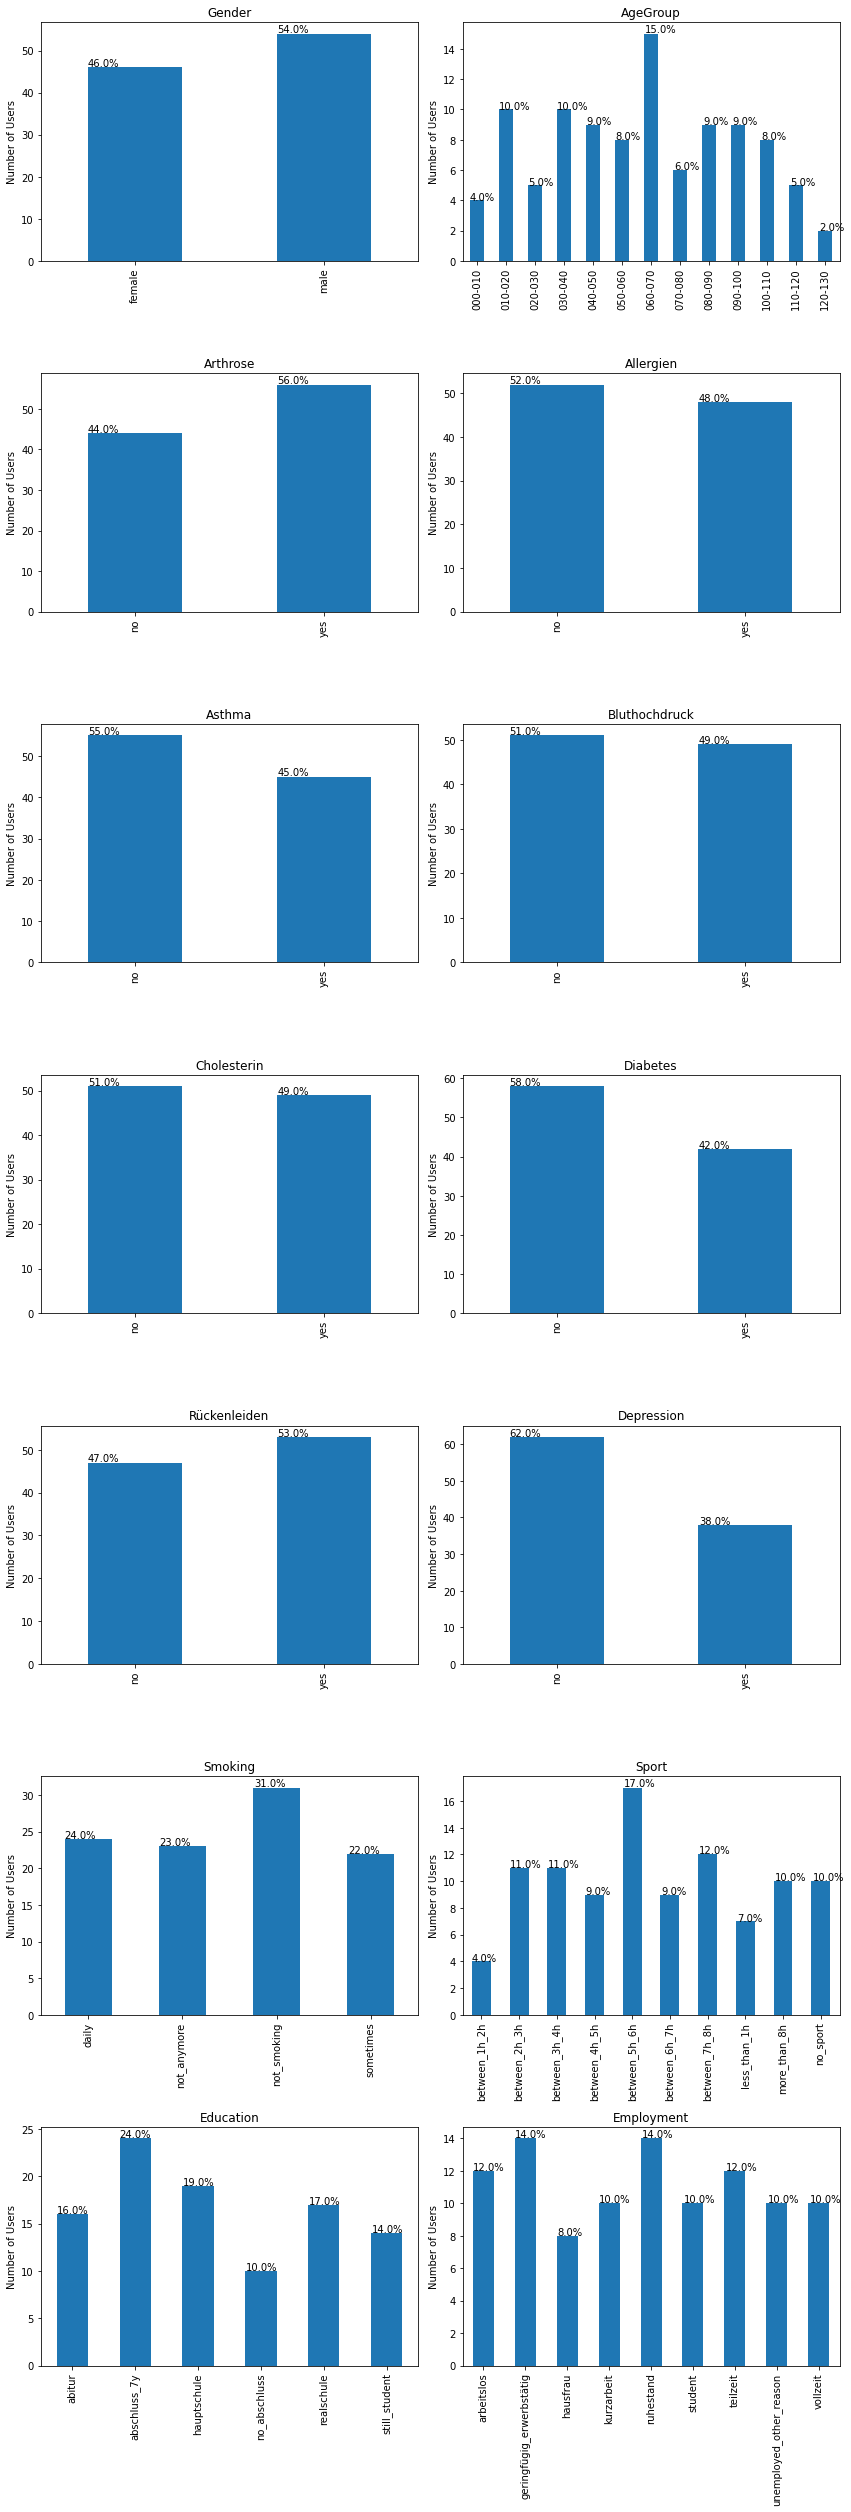

In [34]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(7,2, figsize=(12,35))

columns = ['Gender', 'AgeGroup', 'Arthrose', 'Allergien', 'Asthma', 
           'Bluthochdruck', 'Cholesterin', 'Diabetes', 'Rückenleiden', 'Depression',
           'Smoking', 'Sport', 'Education', 'Employment']

def tag_bars(ax, size=None):
    for p in ax.patches:
        value = f'{round(100 * p.get_height() / size, 2)}%' if size else f'{p.get_height()}'
        ax.annotate(value, (p.get_x() * 1.005, p.get_height() * 1.005))

Display.header('Participants distribution', 'h2')

for i in range(len(columns)):
    ax1 = ax[int(i/2), i%2]
    column_name = columns[i]
    value_counts = demo_df[column_name].value_counts().sort_index()
    value_counts.plot(kind="bar", ylabel='Number of Users', title=column_name, ax=ax1)
    tag_bars(ax1, demo_df.shape[0])
    
fig.tight_layout()

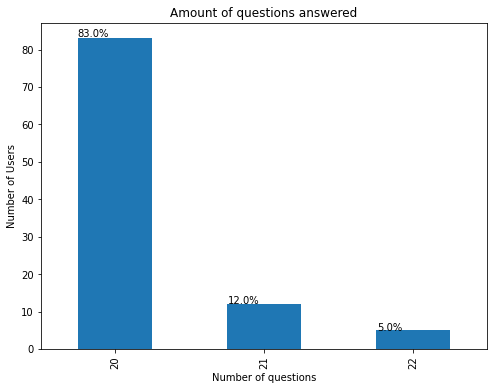

In [35]:
Display.header('Number of questionnaires answered', 'h2')
fig, ax1 = plt.subplots(1,1, figsize=(8,6))

df = responses_df[['ALP_ID', 'QUESTIONNAIRE', 'LINK_ID']].drop_duplicates()
df = df.groupby(by=['ALP_ID']).size().reset_index().rename(columns={0:'count'})
vc1 = df['count'].value_counts().sort_index()
vc1.plot(kind="bar", ylabel='Number of Users', xlabel="Number of questions", title='Amount of questions answered', ax=ax1)
tag_bars(ax1, df.shape[0])

Current week is: 13,2022


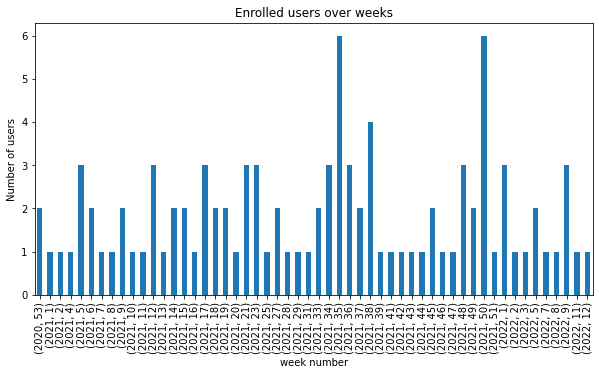

In [36]:
def get_last_questionnaire(responses_df, questionnaire_id):
    result = responses_df[(responses_df['QUESTIONNAIRE'] == questionnaire_id)]
    result = result.groupby(by=['ALP_ID'], as_index=False)
    result = result.agg({'AUTHORED': ['max']})
    result.columns = ['ALP_ID', 'DATETIME']
    return result

def distribute_users_by_week(df, date_column, count_column):
    df['date_week'] = df[date_column].apply(lambda x: x.isocalendar()[1])
    df['date_year'] = df[date_column].apply(lambda x: x.isocalendar()[0])
    week_groups = df.groupby(by =['date_year', 'date_week'])[count_column].count()
    return week_groups

def get_current_week():    
    week_now = datetime.now().date().isocalendar()[1]
    year_now = datetime.now().date().isocalendar()[0]
    return f'{week_now},{year_now}'

Display.header('Participants enrollment', 'h2')
print('Current week is:', get_current_week())
df = get_last_questionnaire(responses_df, 'S1')
value_count = distribute_users_by_week(df, 'DATETIME', 'ALP_ID')
value_count.plot(kind='bar',figsize=(10,5),legend=None, ylabel='Number of users', xlabel='week number', title='Enrolled users over weeks');